In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [ ]:
import seaborn as sns
from scipy import ndimage
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
from joblib import Parallel, delayed

In [ ]:
pip install kaggle_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement kaggle_datasets (from versions: none)
ERROR: No matching distribution found for kaggle_datasets


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(gpus))
if gpus:
    print(f"Found {len(gpus)} GPU")
try:
     for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

Num GPUs: 1
Found 1 GPU


In [ ]:
import matplotlib.pyplot as plt
import PIL
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.12.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

In [ ]:
import zipfile
from google.colab import files
uploaded = files.upload()

In [ ]:
import os
zip_ref = zipfile.ZipFile("archive.zip",'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [ ]:
base_dir = 'tmp/Alzheimer_s Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [ ]:
##############my_code_##############
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(train_dir, target_size = IMAGE_SIZE,
                                             batch_size = BATCH_SIZE)
val_ds = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE,
                                             batch_size = BATCH_SIZE)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
#     validation_split=0.2,
#     subset="training",
#     seed=1337,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=1337,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
) 

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 1279 files belonging to 4 classes.
Using 255 files for validation.


In [ ]:
#Class_names
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# DATA AUGMENTATION

# In this section we apply data augmentation. it is used to increase the diversity of the training set by applying random (but realistic) transformations, such as image rotation. In this way we can reach a better and improved data variability. We decided to use the Keras preprocessing layers, such as

# tf.keras.layers.Resizing, which resizes images.
# tf.keras.layers.Rescaling, which rescales input values to a new range.
# tf.keras.layers.RandomFlip, which randomly flips images during training.
# tf.keras.layers.RandomRotation, which randomly rotates images during training.

In [ ]:
IMG_SIZE = 140
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

AttributeError: ignored

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: ignored

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "tmp/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
  
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/598.5 MB 131.7 MB/s eta 0:00:05
ERROR: Operation cancelled by user


In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc'), Precision(name = 'precision'),Recall(name = 'recall'), 'accuracy']
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 100)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
#                                                      restore_best_weights=True)

In [ ]:
EPOCHS = 200
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, lr_scheduler, ReduceLROnPlateau(patience=10, factor=.5)],
    epochs=EPOCHS
)

Epoch 1/200
321/321 [==============================] - 76s 154ms/step - loss: 1.1242 - auc: 0.7669 - precision: 0.5118 - recall: 0.2798 - accuracy: 0.4665 - val_loss: 3.6552 - val_auc: 0.7079 - val_precision: 0.5233 - val_recall: 0.5098 - val_accuracy: 0.5176 - lr: 0.0100
Epoch 2/200
321/321 [==============================] - 47s 145ms/step - loss: 0.9986 - auc: 0.8027 - precision: 0.6165 - recall: 0.2837 - accuracy: 0.5026 - val_loss: 9.8892 - val_auc: 0.6818 - val_precision: 0.5004 - val_recall: 0.5004 - val_accuracy: 0.5004 - lr: 0.0098
Epoch 3/200
321/321 [==============================] - 47s 145ms/step - loss: 0.9939 - auc: 0.8030 - precision: 0.6461 - recall: 0.2652 - accuracy: 0.5034 - val_loss: 1.1369 - val_auc: 0.6955 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3143 - lr: 0.0095
Epoch 4/200
321/321 [==============================] - 47s 146ms/step - loss: 0.9854 - auc: 0.8061 - precision: 0.6776 - recall: 0.2511 - accuracy: 0.5034 - val_loss: 0.9553

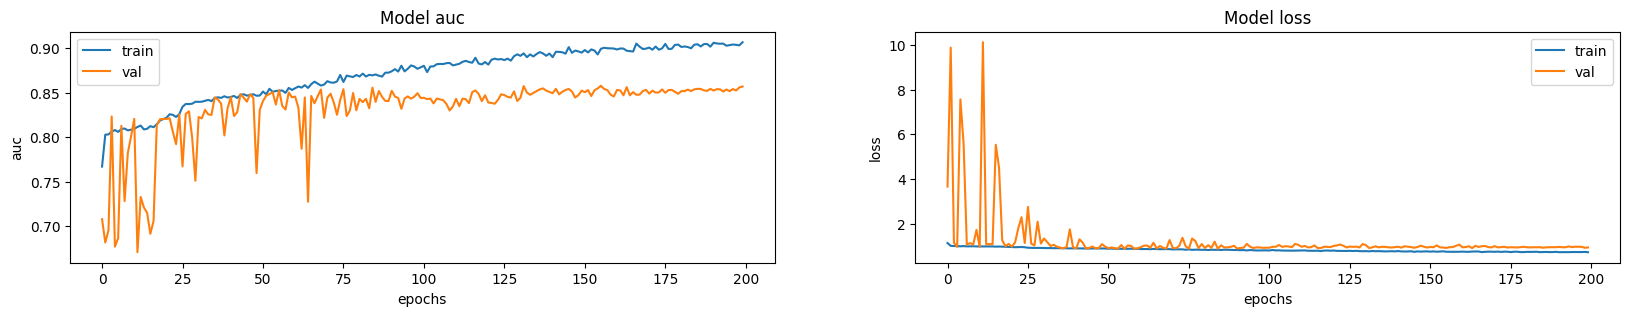

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "tmp/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1279 files belonging to 4 classes.


In [ ]:
_= model.evaluate(test_ds)

80/80 [==============================] - 1s 14ms/step - loss: 442.2870 - auc: 0.6669 - precision: 0.5004 - recall: 0.5004 - accuracy: 0.5004
